In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
time = torch.arange(0, 20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

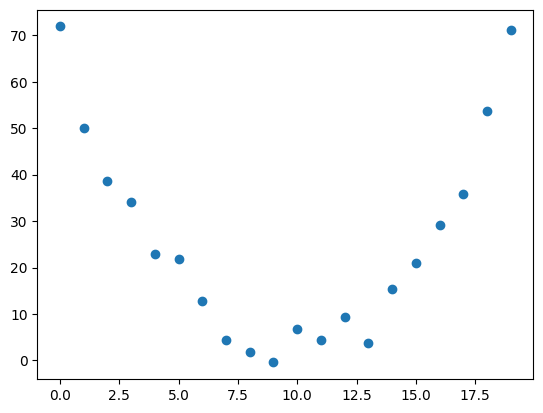

In [3]:
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5)**2 + 1
plt.scatter(time, speed)

In [4]:
def f(t, params):
  a,b, c = params
  return a*(t**2) + (b*t) + c

### Loss function

In [5]:
def mse(preds, targets):
  return ((preds - targets)**2).mean()

### Initializing the parameters

In [6]:
params = torch.randn(3).requires_grad_()

In [7]:
orig_params = params.clone()

### Calculate predictions

In [8]:
preds = f(time, params)

In [9]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, preds.data.cpu().numpy(), color="red")
  ax.set_ylim(-300, 100)

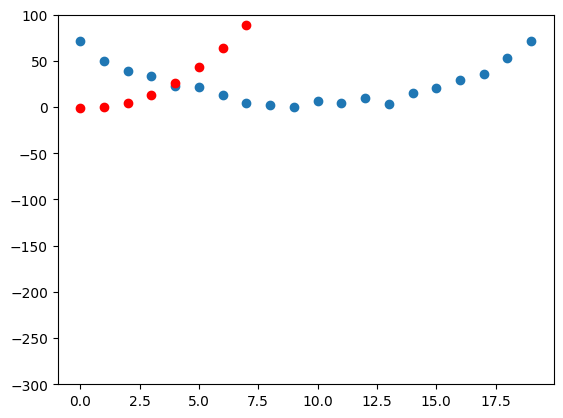

In [10]:
show_preds(preds)

### Calculating the loss

In [11]:
loss = mse(preds, speed)
loss

tensor(93492.3594, grad_fn=<MeanBackward0>)

### Calculate the gradients

In [12]:
loss.backward()
params.grad

tensor([102206.3594,   6531.8979,    424.9787])

### Stepping the weights

In [13]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [14]:
preds = f(time, params)
mse(preds, speed)

tensor(18233.5469, grad_fn=<MeanBackward0>)

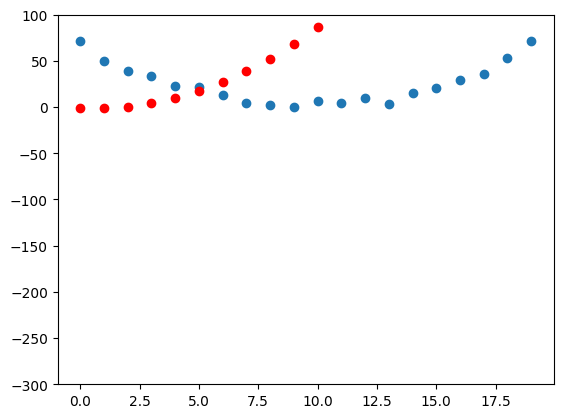

In [15]:
show_preds(preds)

In [16]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [17]:
for i in range(10): apply_step(params)

18233.546875
3992.26806640625
1297.3731689453125
787.4061279296875
690.89404296875
672.6202392578125
669.151611328125
668.4844970703125
668.3475341796875
668.3108520507812


In [18]:
params = orig_params.detach().requires_grad_()

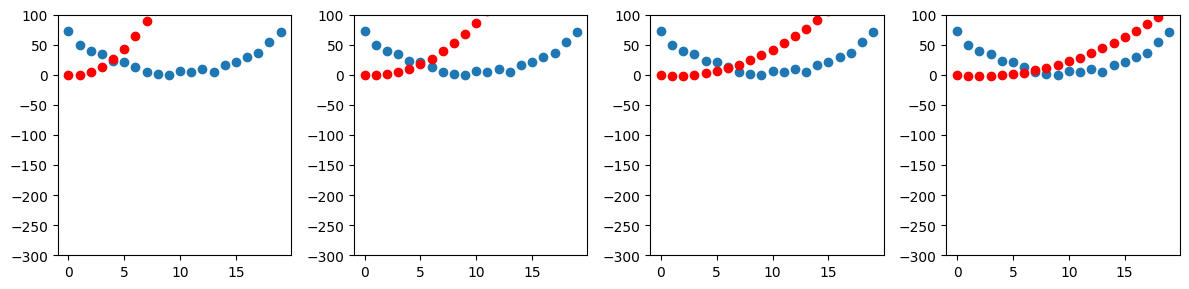

In [19]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### More complex example

In [20]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [21]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [22]:
classes = train_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


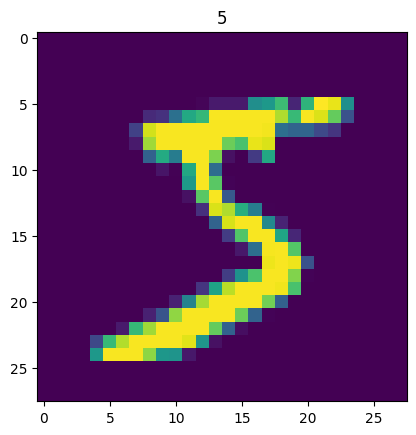

In [23]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd764c618a0>, <torch.utils.data.dataloader.DataLoader object at 0x7fd764c61630>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [25]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [26]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [27]:
weights = init_params((28*28,1))
bias = init_params(1)

In [28]:
def linear1(xb): return xb@weights + bias

In [29]:
train_features_batch[:4].shape

torch.Size([4, 1, 28, 28])

In [64]:
preds = linear1(torch.flatten(train_features_batch[:4], start_dim=1))
preds.shape

torch.Size([4, 1])

In [31]:
from torch import nn

loss_fn = nn.CrossEntropyLoss()

In [32]:
train_labels_batch[:4].shape, preds.shape

(torch.Size([4]), torch.Size([4, 1]))

In [43]:
preds = torch.squeeze(preds)

In [48]:
mnist_loss = loss_fn(preds, train_labels_batch[:4].type(torch.float32))
mnist_loss

tensor(88.1407, grad_fn=<DivBackward1>)

In [49]:
mnist_loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(0.3669), tensor([1.1921e-06]))

In [60]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  #preds = torch.squeeze(preds)
  _loss = mnist_loss(preds, yb)
  loss.backward()

In [77]:
params = weights, bias

In [81]:
from tqdm.auto import tqdm

epochs = 100
train_loss, train_acc = 0, 0
optimizer = torch.optim.SGD(params=params,
                            lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        #model_0.train()
        # 1. Forward pass
        X.shape
        y_pred = linear1(torch.flatten(X, start_dim=1))

        # 2. Calculate loss (per batch)
        loss = loss_fn(torch.squeeze(y_pred), y.type(torch.float32))
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        #optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

        # 5. Optimizer step
        #optimizer.step()

    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 28928.92383 | Train accuracy: 0.00%
Epoch: 1
-------
Train loss: 28171.68945 | Train accuracy: 0.00%
Epoch: 2
-------
Train loss: 27516.85352 | Train accuracy: 0.00%
Epoch: 3
-------
Train loss: 26936.44531 | Train accuracy: 0.00%
Epoch: 4
-------
Train loss: 26420.52539 | Train accuracy: 0.00%
Epoch: 5
-------
Train loss: 25955.17383 | Train accuracy: 0.00%
Epoch: 6
-------
Train loss: 25521.43750 | Train accuracy: 0.00%
Epoch: 7
-------
Train loss: 25116.18359 | Train accuracy: 0.00%
Epoch: 8
-------
Train loss: 24740.45703 | Train accuracy: 0.00%
Epoch: 9
-------
Train loss: 24389.59570 | Train accuracy: 0.00%
Epoch: 10
-------
Train loss: 24058.40820 | Train accuracy: 0.00%
Epoch: 11
-------
Train loss: 23743.82422 | Train accuracy: 0.00%
Epoch: 12
-------
Train loss: 23443.90430 | Train accuracy: 0.00%
Epoch: 13
-------
Train loss: 23157.44336 | Train accuracy: 0.00%
Epoch: 14
-------
Train loss: 22883.07617 | Train accuracy: 0.00%
Epoch: 15
-------
Tr